---------------------------------------------------------------------------------------------------------------------------------------------------

# Stock Price Prediction for Indian Market

---------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
# Run this to setup your env
#%pip install -r requirements.txt

# Imports

In [2]:
import pandas as pd
from NseXRBL import *
from Preprocessing import *
from Sentiments import *
from feature_engineer import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, median_absolute_error
from xgboost import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

Setting Defaults

In [3]:
stock_name = 'Zomato' 
market = '.NS' # For NSE, Indian market

fillings_file_path = f'Data/{stock_name}/CF-FR-equities-ZOMATO-24-Mar-2025.csv'
financial_file_path = f"Data/{stock_name}/{stock_name}_Financials.xlsx"
stock_price_file_path = f"./Data/{stock_name}/{stock_name}.csv"
sentiment_file_path = f'Data/{stock_name}/{stock_name}_sentiments.csv'
model_data_file_path = f'Data/{stock_name}/{stock_name}_model.csv'

-------------------------------------------------------------------------------------------------------------------

# 1) Data Extraction

### Getting quarterly financial data fron NSE (National stock exchange, India)

https://www.nseindia.com/companies-listing/corporate-filings-financial-results

![Alt Text](Images/Image1.png)


*`Note: I am not using refinitv for this as it does not have correct quarterly data for indian stocks, plus NSE has more novelity than refinitiv as listed companies are required to submit their fillings on NSE (goverment website) first.`*

In [4]:
df_fillings = pd.read_csv(fillings_file_path)
df_fillings.head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,Exchange Dissemination Time,Time Taken
0,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:29:47,20-Jan-2025 18:30:33,00:00:46
1,Zomato Limited,Un-Audited,Non-cumulative,Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:28:59,20-Jan-2025 18:29:27,00:00:28
2,Zomato Limited,Un-Audited,Non-cumulative,Consolidated,Ind-AS New,Quarterly,30-Sep-2024,Second Quarter,https://nsearchives.nseindia.com/corporate/xbr...,22-Oct-2024 19:01:05,22-Oct-2024 19:01:37,00:00:32


Let's understand this table:- 

- COMPANY NAME : Name of the company

- AUDITED / UNAUDITED : Weather the report sent was audited or not

- CUMULATIVE / NON-CUMULATIVE : The report is Cumalative or not

- CONSOLIDATED / NON-CONSOLIDATED : The company releases 2 reports at same time, consolidated or non-consolidated. The consolidated report will have profits and expense of previous quarters included. where as non-consolidated report will have profits and expense of the particular quarter only (which we want in our case)

- IND AS/ NON IND AS : Its represent the accounting standards used in the report

- PERIOD ENDED : End date of quarter 

- RELATING TO : The report belongs to what quarter (First, Second, Third, )

- ** XBRL : XML link of the the report(in XRBL format)

- Exchange Received Time : At what time the exchange recieved report from the company

- Exchange Dissemination Time : At what time exchange published the report 

- Time Taken : difference between 'Exchange Dissemination Time' and 'Exchange Received Time'

applying preprocessing to clean the data

In [5]:
df_fillings = preprocess_fillings_NonConsolidated_csv(fillings_file_path)
df_fillings.head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,Exchange Dissemination Time,Time Taken
0,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:29:47,20-Jan-2025 18:30:33,00:00:46
3,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Sep-2024,Second Quarter,https://nsearchives.nseindia.com/corporate/xbr...,22-Oct-2024 19:00:01,22-Oct-2024 19:00:31,00:00:30
5,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2024,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,01-Aug-2024 18:59:42,01-Aug-2024 18:59:58,00:00:16


In [6]:
# Testing
Xml_Extract_Financials(df_fillings['** XBRL'].iloc[0])

,FullTag,Value
0,RevenueFromOperations,22260000000.00
1,OtherIncome,3110000000.00
2,Income,25370000000.00
3,CostOfMaterialsConsumed,0.00
4,PurchasesOfStockInTrade,0.00
5,ChangesInInventoriesOfFinishedGoodsWorkInProgr...,0.00
6,EmployeeBenefitExpense,3330000000.00
7,FinanceCosts,40000000.00
8,DepreciationDepletionAndAmortisationExpense,270000000.00
9,OtherExpenses,15990000000.00


Here we are successfully able to extract financial report from the xml link

But from this we want only few important values like, Income, Revenue, Expenses etc.

In [7]:
# Testing
Extract_Important_Financials(df_fillings['** XBRL'].iloc[0])

,Total_Revenue,RevenueFromOperations,ProfitBeforeTax,FinanceCosts,DepreciationDepletionAndAmortisationExpense,Total_Expenses
0,2.537000e+10,2.226000e+10,5.740000e+09,40000000.0,270000000.0,1.963000e+10


My functions are working fine, so let's apply it to all rows

In [8]:
new_financial_data = df_fillings['** XBRL'].apply(Extract_Important_Financials)
# Concatenate results into a DataFrame
financial_df = pd.concat(new_financial_data.tolist(), axis=0).reset_index(drop=True)

# Concatenate with original df_fillings
financial_df = pd.concat([df_fillings.reset_index(drop=True), financial_df], axis=1)

financial_df.head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,Exchange Dissemination Time,Time Taken,Total_Revenue,RevenueFromOperations,ProfitBeforeTax,FinanceCosts,DepreciationDepletionAndAmortisationExpense,Total_Expenses
0,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:29:47,20-Jan-2025 18:30:33,00:00:46,2.537000e+10,2.226000e+10,5.740000e+09,40000000.0,270000000.0,1.963000e+10
1,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Sep-2024,Second Quarter,https://nsearchives.nseindia.com/corporate/xbr...,22-Oct-2024 19:00:01,22-Oct-2024 19:00:31,00:00:30,2.420000e+10,2.151000e+10,4.970000e+09,40000000.0,220000000.0,1.923000e+10
2,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2024,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,01-Aug-2024 18:59:42,01-Aug-2024 18:59:58,00:00:16,2.327000e+10,2.048000e+10,4.700000e+09,40000000.0,190000000.0,1.854000e+10


In [9]:
# checking for null values
financial_df.isnull().sum()

COMPANY NAME                                   0
AUDITED / UNAUDITED                            0
CUMULATIVE / NON-CUMULATIVE                    0
CONSOLIDATED / NON-CONSOLIDATED                0
IND AS/ NON IND AS                             0
PERIOD                                         0
PERIOD ENDED                                   0
RELATING TO                                    0
** XBRL                                        0
Exchange Received Time                         0
Exchange Dissemination Time                    0
Time Taken                                     0
Total_Revenue                                  0
RevenueFromOperations                          0
ProfitBeforeTax                                0
FinanceCosts                                   0
DepreciationDepletionAndAmortisationExpense    0
Total_Expenses                                 0
dtype: int64

In [10]:
# saving results
financial_df.to_excel(financial_file_path, index=False)

-------------------------------------------------------------------------------------------------------------------

### Getting historical stock price data

Checking if the data file already exists or not

If the file does not exist, download the complete data from yahoo finance

In [11]:
stock_price_df = preprocess_stock_price_data(stock_name, market, stock_price_file_path)
stock_price_df.sort_values('Date', ascending=False).head(3)

The CSV file is already up to date.


,Date,Adj Close,Close,High,Low,Open,Volume
910,2025-03-27,NaN,206.279999,208.750000,200.369995,204.470001,400388098.0
909,2025-03-26,NaN,203.289993,206.899994,199.919998,202.350006,114342130.0
908,2025-03-25,NaN,211.160004,225.100006,210.600006,223.800003,62162487.0


-------------------------------------------------------------------------------------------------------------------

### Getting Headlines Data for Sentimental Analysis

In [12]:
headlines_df = preprocess_sentiment_file(stock_name, market, sentiment_file_path)
headlines_df.sort_values('Date', ascending=False).head()

The CSV file is already up to date.


,Date,Articles,Aggregated Sentiment Score
1343,2025-03-27,"[NSE Index Rejig, Zomato Shares, Jio FInancial...",0.023750
1342,2025-03-26,[Zomato Share Prices Stay Above Opening Thresh...,0.016001
1341,2025-03-25,[Zomato Share Price Highlights : Zomato closed...,0.020348
1340,2025-03-24,[Zomato Share Price Highlights : Zomato closed...,0.050704
1339,2025-03-23,"[Zomato, Kondapur restaurant fined for deliver...",0.000000


Using Google News to fetch latest market news of the company by web scrapping.

In this section I will find all the news of the company since it has been listed in stock market.

In [13]:
# Find the rows where 'Articles' is empty
empty_articles_rows = headlines_df[headlines_df['Articles'].isnull()]

headlines_df.loc[empty_articles_rows.index, 'Articles'] = empty_articles_rows['Date'].apply(lambda date: get_google_news(stock_name, date))

headlines_df.sort_values('Date', ascending=False).head()


,Date,Articles,Aggregated Sentiment Score
1343,2025-03-27,"[NSE Index Rejig, Zomato Shares, Jio FInancial...",0.023750
1342,2025-03-26,[Zomato Share Prices Stay Above Opening Thresh...,0.016001
1341,2025-03-25,[Zomato Share Price Highlights : Zomato closed...,0.020348
1340,2025-03-24,[Zomato Share Price Highlights : Zomato closed...,0.050704
1339,2025-03-23,"[Zomato, Kondapur restaurant fined for deliver...",0.000000


*`Note: I am not using refinitiv api for this as it does not have old news headlines data for this stock`*

In [14]:
# Save progress
headlines_df.to_csv(sentiment_file_path, index= False)

Now, we will mark each article with a sentiment score. 

Interpretation of Sentiment Score:
Range: Sentiment scores typically range from -1 to +1.
Negative values (below 0): Negative sentiment.
Positive values (above 0): Positive sentiment.
Around 0: Neutral or mixed sentiment.

Since, there could be multiple articles from different sources about the company, which shows different opinions of people, we will aggregate the sentiment score for each day.

In [15]:
# Rows where Aggregated Sentiment Score is empty
empty_score_rows = headlines_df[headlines_df['Aggregated Sentiment Score'].isnull() & headlines_df['Articles'].notnull()]

# Apply the function to calculate sentiment score
headlines_df.loc[empty_score_rows.index,'Aggregated Sentiment Score'] = empty_score_rows['Articles'].apply(get_aggregated_sentiment)

# Display the updated DataFrame
headlines_df.sort_values('Date', ascending=False).head()

,Date,Articles,Aggregated Sentiment Score
1343,2025-03-27,"[NSE Index Rejig, Zomato Shares, Jio FInancial...",0.023750
1342,2025-03-26,[Zomato Share Prices Stay Above Opening Thresh...,0.016001
1341,2025-03-25,[Zomato Share Price Highlights : Zomato closed...,0.020348
1340,2025-03-24,[Zomato Share Price Highlights : Zomato closed...,0.050704
1339,2025-03-23,"[Zomato, Kondapur restaurant fined for deliver...",0.000000


Here, I was able to successfully score each article. And then was able to find its aggregated Sentiment score.

eg, 
What 0.0759 Means:
A score of 0.0759 is slightly positive, indicating that the overall sentiment of the article titles in that row is mildly optimistic or slightly favorable. However, it is not a strong positive sentiment. This suggests:

The articles may contain neutral to mildly positive language.
The content could be balanced, with both positive and negative aspects discussed, but with a slight lean towards positivity.

In [16]:
# Save progress
headlines_df.to_csv(sentiment_file_path, index= False)

Future scope for optimization...

"*To add this feature into our model, which should aggreate it further more considering the market holidays.* 
*Eg, A company news came on saturday, sunday and monday, will have a impact on its stock on monday. or holidays like chritsmas etc.*"

-------------------------------------------------------------------------------------------------------------------

# 2) Feature Engineering & Data Modeling

Loading the Dataset

In [17]:
financials_data = pd.read_excel(financial_file_path)
stock_data = pd.read_csv(stock_price_file_path)
sentiments_data = pd.read_csv(sentiment_file_path)

## Financial data

In [18]:
financials_data.head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,Exchange Dissemination Time,Time Taken,Total_Revenue,RevenueFromOperations,ProfitBeforeTax,FinanceCosts,DepreciationDepletionAndAmortisationExpense,Total_Expenses
0,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:29:47,20-Jan-2025 18:30:33,00:00:46,25370000000,22260000000,5740000000,40000000,270000000,19630000000
1,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Sep-2024,Second Quarter,https://nsearchives.nseindia.com/corporate/xbr...,22-Oct-2024 19:00:01,22-Oct-2024 19:00:31,00:00:30,24200000000,21510000000,4970000000,40000000,220000000,19230000000
2,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2024,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,01-Aug-2024 18:59:42,01-Aug-2024 18:59:58,00:00:16,23270000000,20480000000,4700000000,40000000,190000000,18540000000


List of feature I will add in this:-

1) **Operating Margin :** `ProfitBeforeTax / Total_Revenue`

2) **EBITDA :** `ProfitBeforeTax + FinanceCosts + DepreciationDepletionAndAmortisationExpense`

3) **EBITDA Margin :** `EBITDA / Total_Revenue`

4) **Profit Margin :** `ProfitBeforeTax / Total_Revenue`

5) **Revenue Contribution :** `RevenueFromOperations / Total_Revenue`

6) **Expense Ratio :** `Total_Expenses / Total_Revenue`

7) **Depreciation Ratio :** `DepreciationDepletionAndAmortisationExpense / Total_Revenue`

8) **FinanceCost Ratio :** `FinanceCosts / Total_Revenue`

In [19]:
financials_data = add_financial_ratios(financials_data)
financials_data['Published_Date'] = pd.to_datetime(financials_data['Exchange Dissemination Time'], 
                                                            format= '%d-%b-%Y %H:%M:%S').dt.strftime('%Y-%m-%d')
financials_data.head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,...,DepreciationDepletionAndAmortisationExpense,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,Published_Date
0,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,31-Dec-2024,Third Quarter,https://nsearchives.nseindia.com/corporate/xbr...,20-Jan-2025 18:29:47,...,270000000,19630000000,0.23,6050000000,0.24,0.23,0.88,0.77,0.01,2025-01-20
1,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Sep-2024,Second Quarter,https://nsearchives.nseindia.com/corporate/xbr...,22-Oct-2024 19:00:01,...,220000000,19230000000,0.21,5230000000,0.22,0.21,0.89,0.79,0.01,2024-10-22
2,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2024,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,01-Aug-2024 18:59:42,...,190000000,18540000000,0.20,4930000000,0.21,0.20,0.88,0.80,0.01,2024-08-01


## Stock price data

In [20]:
stock_data.head(3)

,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-07-23,126.000000,126.000000,138.899994,115.000000,116.000000,694895290.0
1,2021-07-26,140.649994,140.649994,143.750000,125.300003,126.349998,249723854.0
2,2021-07-27,132.899994,132.899994,147.800003,127.750000,141.699997,240341900.0


List of feature I will add in this:-

1) **Daily Return :** `Closing price percentage change`

2) **Intraday Range (Volatility Indicator) :** `Day High - Day Low`

3) **Close/Open :** `Closing price / Opening price `

4) **High/Low :** `ProfitBeforeTax / Total_Revenue`

5) **Price Movement Direction (Up/Down) :** `If Close > Open means upward direction (1), else downward (0)`

6) **Rolling Statistics (Moving Averages) :** `SMA 10 and SMA 30`

7) **Rolling Volatility :** `Volatility 10 and Momentum 5D`

8) **Volume-Based Indicators :** `Volume_Change and Volume_Avg_10`

9) **Relative Strength Index (RSI) :** `RSI using talib library`

In [21]:
stock_data = add_price_features(stock_data)
stock_data.head(3)

,Date,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Intraday_Range,Close/Open,High/Low,Direction,SMA_10,SMA_30,Volatility_10,Momentum_5D,Volume_Avg_10,RSI
0,2021-07-23,126.000000,126.0,138.0,115.0,116.0,694895290.0,NaN,23.0,1.09,1.20,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-07-26,140.649994,140.0,143.0,125.0,126.0,249723854.0,11.11,18.0,1.11,1.14,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-07-27,132.899994,132.0,147.0,127.0,141.0,240341900.0,-5.71,20.0,0.94,1.16,0,NaN,NaN,NaN,NaN,NaN,NaN


## Sentimental data

In [22]:
sentiments_data.head()

,Date,Articles,Aggregated Sentiment Score
0,2021-07-23,['Zomato IPO catapults founder towards list of...,0.062067
1,2021-07-24,['Zomatos Deepinder Goyal Is Now A Billionaire...,0.076988
2,2021-07-25,['Rally in Zomato can be sustainable in near t...,0.060000
3,2021-07-26,['Zomato share gains for second straight sessi...,0.080000
4,2021-07-27,"[""Inside Zomato and Universal Music Group's re...",0.058333


No more feature can be derived from this

## Date Modeling

In [23]:
# Converting Date columns to pandas datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
sentiments_data['Date'] = pd.to_datetime(sentiments_data['Date'])
financials_data['Published_Date'] = pd.to_datetime(financials_data['Published_Date'])

Since the report can be published in weekend or national holiday when the stock market is closed, It would difficult to merge them as it is. 

So, to solve this I will Expand each row into 3 rows (D, D+1, D+2)

In [24]:
Days = 2 # Offset
temp = financials_data.copy()

for i in range(Days):
    temp['Published_Date'] = temp['Published_Date']  + pd.Timedelta(days=1)
    financials_data = pd.concat([temp, financials_data])

financials_data.sort_values('Published_Date').head(3)

,COMPANY NAME,AUDITED / UNAUDITED,CUMULATIVE / NON-CUMULATIVE,CONSOLIDATED / NON-CONSOLIDATED,IND AS/ NON IND AS,PERIOD,PERIOD ENDED,RELATING TO,** XBRL,Exchange Received Time,...,DepreciationDepletionAndAmortisationExpense,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,Published_Date
14,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2021,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,11-Aug-2021 11:55:25,...,319000000,11187000000,-0.35,-2571000000,-0.31,-0.35,0.92,1.35,0.04,2021-08-11
14,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2021,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,11-Aug-2021 11:55:25,...,319000000,11187000000,-0.35,-2571000000,-0.31,-0.35,0.92,1.35,0.04,2021-08-12
14,Zomato Limited,Un-Audited,Non-cumulative,Non-Consolidated,Ind-AS New,Quarterly,30-Jun-2021,First Quarter,https://nsearchives.nseindia.com/corporate/xbr...,11-Aug-2021 11:55:25,...,319000000,11187000000,-0.35,-2571000000,-0.31,-0.35,0.92,1.35,0.04,2021-08-13


In [25]:
# removing unwanted column (this column had some null values which can cause issue while doing dropna later)
stock_data.drop(['Adj Close'], axis=1,inplace = True)

Merging all the datasets

In [26]:
Model_data = pd.merge(stock_data, sentiments_data, how='left', on='Date')
Model_data = pd.merge(Model_data, financials_data, how='left', left_on='Date', right_on='Published_Date')
Model_data.head(3)

,Date,Close,High,Low,Open,Volume,Daily_Return,Intraday_Range,Close/Open,High/Low,...,DepreciationDepletionAndAmortisationExpense,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,Published_Date
0,2021-07-23,126.0,138.0,115.0,116.0,694895290.0,NaN,23.0,1.09,1.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,2021-07-26,140.0,143.0,125.0,126.0,249723854.0,11.11,18.0,1.11,1.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2021-07-27,132.0,147.0,127.0,141.0,240341900.0,-5.71,20.0,0.94,1.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [27]:
# applying forward fill to handle null values from financial data
Model_data = Model_data.ffill()
# Remove null values
Model_data = Model_data.dropna()
Model_data.head(3)

,Date,Close,High,Low,Open,Volume,Daily_Return,Intraday_Range,Close/Open,High/Low,...,DepreciationDepletionAndAmortisationExpense,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,Published_Date
29,2021-09-03,149.0,151.0,135.0,135.0,113381518.0,8.76,16.0,1.10,1.12,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13
30,2021-09-06,144.0,149.0,143.0,149.0,34811620.0,-3.36,6.0,0.97,1.04,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13
31,2021-09-07,140.0,146.0,138.0,144.0,30421931.0,-2.78,8.0,0.97,1.06,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13


`One last feature we can add is 'how old is the financial report from the trading day'. This will act as a weight because right now for eg, 1-90 days all will have same financial data in the dataset, but the impact of the report published on day 1 won't be same as of day 90 for that quarter.`

In [28]:
Model_data['ReportPublishedWeight'] = 101 - (Model_data['Date'] - Model_data['Published_Date']).dt.days
Model_data.head(3)

,Date,Close,High,Low,Open,Volume,Daily_Return,Intraday_Range,Close/Open,High/Low,...,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,Published_Date,ReportPublishedWeight
29,2021-09-03,149.0,151.0,135.0,135.0,113381518.0,8.76,16.0,1.10,1.12,...,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13,80
30,2021-09-06,144.0,149.0,143.0,149.0,34811620.0,-3.36,6.0,0.97,1.04,...,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13,77
31,2021-09-07,140.0,146.0,138.0,144.0,30421931.0,-2.78,8.0,0.97,1.06,...,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,2021-08-13,76


In [29]:
print(f"Min days between report published and trading days: {Model_data['ReportPublishedWeight'].min()}")
print(f"Max days between report published and trading days: {Model_data['ReportPublishedWeight'].max()}")

Min days between report published and trading days: 0
Max days between report published and trading days: 101


#### Define Target columns

In [30]:
Model_data['Target_Price'] = Model_data['Close'].shift(-1)
Model_data['Buy_Sell_signal'] = (Model_data['Target_Price'] > Model_data['Close']).astype(int)
Model_data.dropna(inplace=True)

In [31]:
# Save progress
Model_data.to_csv(model_data_file_path, index=False)

-------------------------------------------------------------------------------------------------------------------

# 3) Feature Selection

In [32]:
# Loading the dataset
Model_data = pd.read_csv(model_data_file_path)
Model_data.sort_values('Date', inplace=True)

In [33]:
Model_data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return',
       'Intraday_Range', 'Close/Open', 'High/Low', 'Direction', 'SMA_10',
       'SMA_30', 'Volatility_10', 'Momentum_5D', 'Volume_Avg_10', 'RSI',
       'Articles', 'Aggregated Sentiment Score', 'COMPANY NAME',
       'AUDITED / UNAUDITED', 'CUMULATIVE / NON-CUMULATIVE',
       'CONSOLIDATED / NON-CONSOLIDATED', 'IND AS/ NON IND AS', 'PERIOD',
       'PERIOD ENDED', 'RELATING TO', '** XBRL', 'Exchange Received Time',
       'Exchange Dissemination Time', 'Time Taken', 'Total_Revenue',
       'RevenueFromOperations', 'ProfitBeforeTax', 'FinanceCosts',
       'DepreciationDepletionAndAmortisationExpense', 'Total_Expenses',
       'Operating_Margin', 'EBITDA', 'EBITDA_Margin', 'Profit_Margin',
       'Revenue_Contribution', 'Expense_Ratio', 'Depreciation_Ratio',
       'Published_Date', 'ReportPublishedWeight', 'Target_Price',
       'Buy_Sell_signal'],
      dtype='object')

- First phase of selection : remove irrelavant columns

In [34]:
features = ['Target_Price', 'Buy_Sell_signal', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Daily_Return', 'Intraday_Range', 'Close/Open', 'High/Low', 'Direction',
       'SMA_10', 'SMA_30', 'Volatility_10', 'Momentum_5D',
       'Volume_Avg_10', 'RSI', 'Aggregated Sentiment Score', 'Total_Revenue',
       'RevenueFromOperations', 'ProfitBeforeTax', 'FinanceCosts',
       'DepreciationDepletionAndAmortisationExpense', 'Total_Expenses',
       'Operating_Margin', 'EBITDA', 'EBITDA_Margin', 'Profit_Margin',
       'Revenue_Contribution', 'Expense_Ratio', 'Depreciation_Ratio', 'ReportPublishedWeight']

Model_data = Model_data[features]

Model_data.head(3)

,Target_Price,Buy_Sell_signal,Close,High,Low,Open,Volume,Daily_Return,Intraday_Range,Close/Open,...,DepreciationDepletionAndAmortisationExpense,Total_Expenses,Operating_Margin,EBITDA,EBITDA_Margin,Profit_Margin,Revenue_Contribution,Expense_Ratio,Depreciation_Ratio,ReportPublishedWeight
0,144.0,0,149.0,151.0,135.0,135.0,113381518.0,8.76,16.0,1.10,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,80
1,140.0,0,144.0,149.0,143.0,149.0,34811620.0,-3.36,6.0,0.97,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,77
2,141.0,1,140.0,146.0,138.0,144.0,30421931.0,-2.78,8.0,0.97,...,319000000.0,1.118700e+10,-0.35,-2.571000e+09,-0.31,-0.35,0.92,1.35,0.04,76


- Second phase of feature selection:  Select only those features which are highly correlated with the target (positively or negatively) and remove redundant ones (highly correlated with each other).

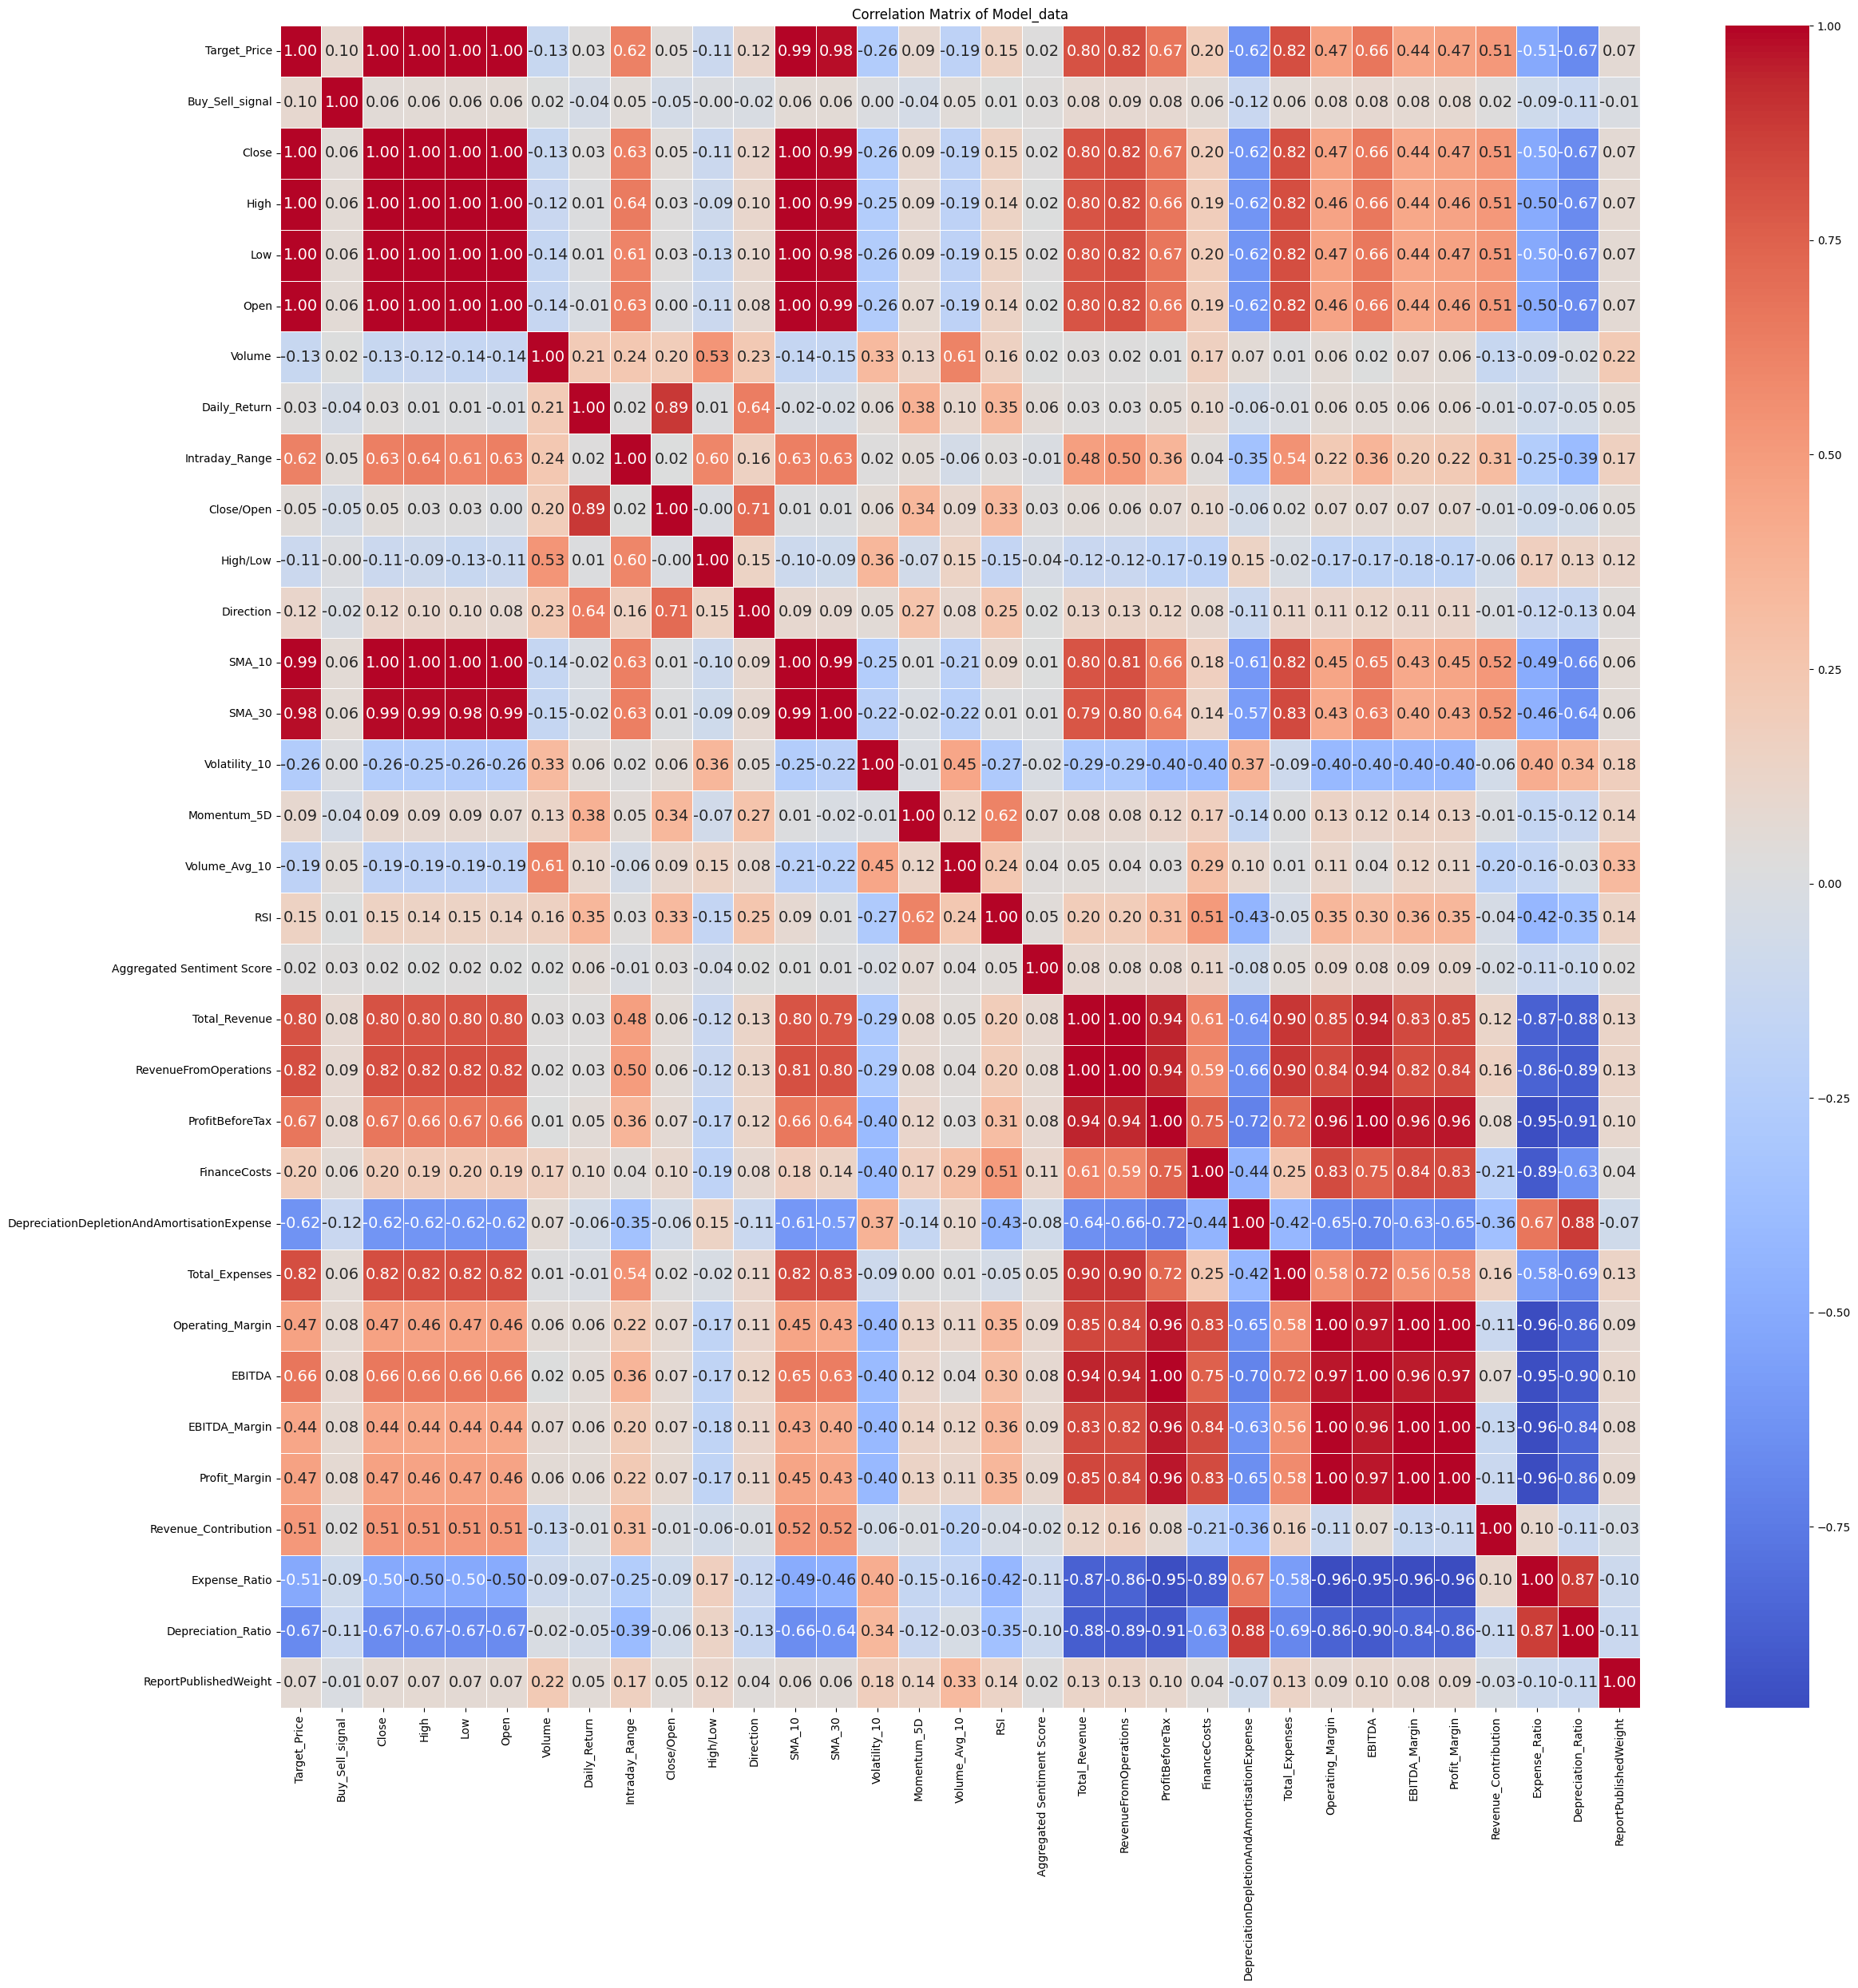

In [35]:
cor_matrix = Model_data.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(cor_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={'size': 14})
plt.title("Correlation Matrix of Model_data")
plt.tight_layout()
plt.show()

We can manully select features which does not have much colinearity with the target columns. And can also pick one column when there is multicolinearity.

But, in XGBoost it auto selects best features

Spliting the data, allocating past 30 days data for backtesting

In [36]:
# Number of days to backtest on
Backtest_days = 30

selected_features = Model_data.columns.drop(["Target_Price", "Buy_Sell_signal"]).to_list()

Train_Data = Model_data.iloc[:-Backtest_days]
Back_Test_Data = Model_data.iloc[-Backtest_days:]

Basic Model (XGBoost Regressor) training

In [37]:
X_train_reg = Train_Data[selected_features]
y_train_reg = Train_Data['Target_Price']

X_test_reg = Back_Test_Data[selected_features]
y_test_reg = Back_Test_Data['Target_Price']

# Regression
reg_model = XGBRegressor(random_state=42)
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)
# Regression metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("Regression: Predict Next Day Price")
print(f"Mean Absolute Error: {mae:.2f}")

Regression: Predict Next Day Price
Mean Absolute Error: 5.86


XGBoost automatically performs internal feature selection during training using:
- Tree-based Splitting: It chooses only the most informative features at each tree split.
- Less useful features may never be used in any split (i.e., they’re ignored).

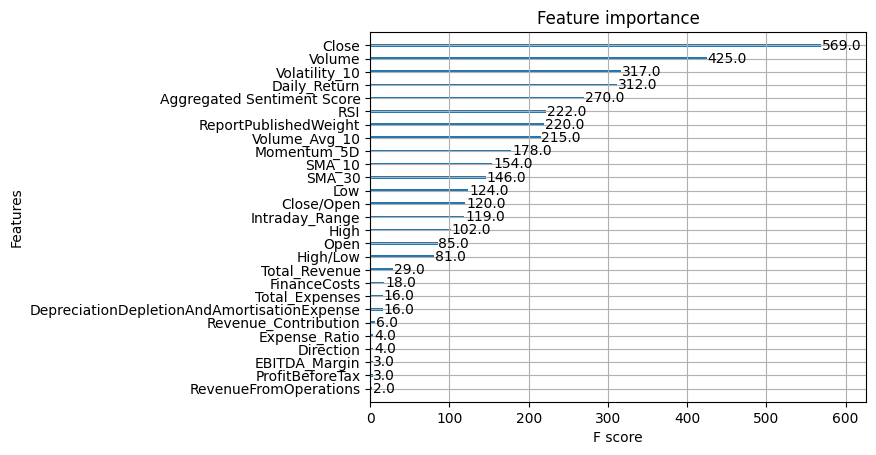

In [38]:
plot_importance(reg_model)
plt.show()

F score = "Frequency score"
It tells you:

"How many times a feature was used to split the data in all trees."

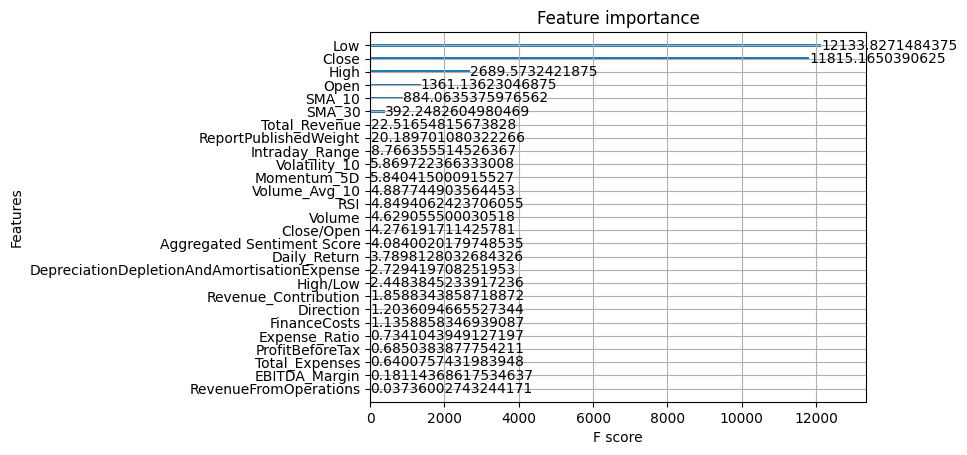

In [39]:
# Avg gain of splits using the feature
plot_importance(reg_model, importance_type='gain')        
plt.show()

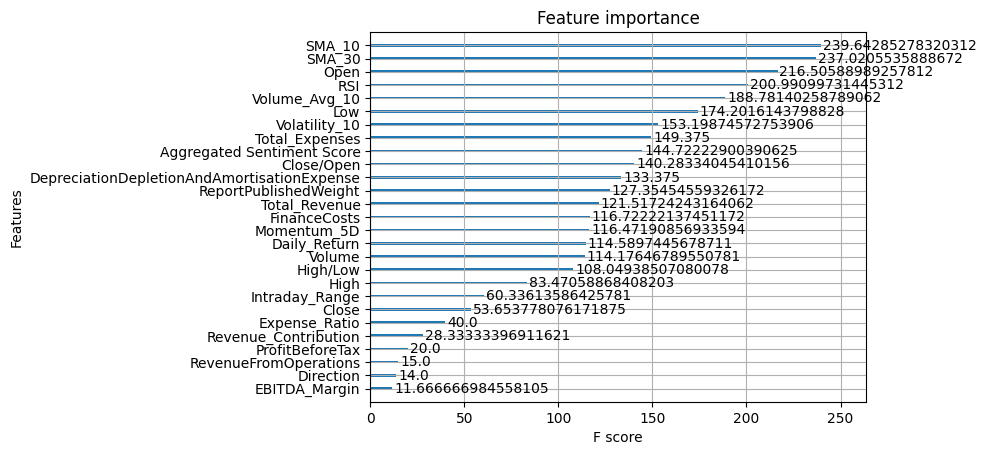

In [40]:
# Avg coverage (samples passed through)
plot_importance(reg_model, importance_type='cover')       
plt.show()

So, there is no further need to select features manually here

Basic model for XGBoost Classifier

In [41]:
# X_train_cls = Train_Data[selected_features]
# y_train_cls = Train_Data['Buy_Sell_signal']

# X_test_cls = Back_Test_Data[selected_features]
# y_test_cls = Back_Test_Data['Buy_Sell_signal']

# # Classifier
# cls_model = XGBClassifier(random_state=42)
# cls_model.fit(X_train_cls, y_train_cls)
# y_pred_cls = cls_model.predict(X_test_cls)

# # Regression metrics
# score = accuracy_score(y_test_cls, y_pred_cls)
# print("Buy Sell signal for next day")
# print(f"accuracy score: {score:.2f}")

---------------------------------------------------------------------------------------------------------------------------------------------------

# 4) Model Training & Hyper parameter tuning

Optimizing regression model

In [42]:
# Define hyperparameter grid
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 5, 10],
}

xgb_model = XGBRegressor(random_state=42)
# RandomizedSearchCV
random_search_reg = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring="neg_median_absolute_error",  # Regression scoring
    cv=5,
    n_jobs=-1,
    random_state=42,
)

random_search_reg.fit(X_train_reg, y_train_reg)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_median_absolute_error')

---------------------------------------------------------------------------------------------------------------------------------------------------

# 5) Model Evaluation & Backtesting for past 30 days

In [43]:
y_pred_reg = random_search_reg.predict(X_test_reg)

# Regression metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("Regression: Predict Next Day Price")
print(f"Mean Absolute Error: {mae:.2f}")
print(f'Median Absolute Error: ', median_absolute_error(y_test_reg, y_pred_reg))

Regression: Predict Next Day Price
Mean Absolute Error: 4.88
Median Absolute Error:  4.7813720703125


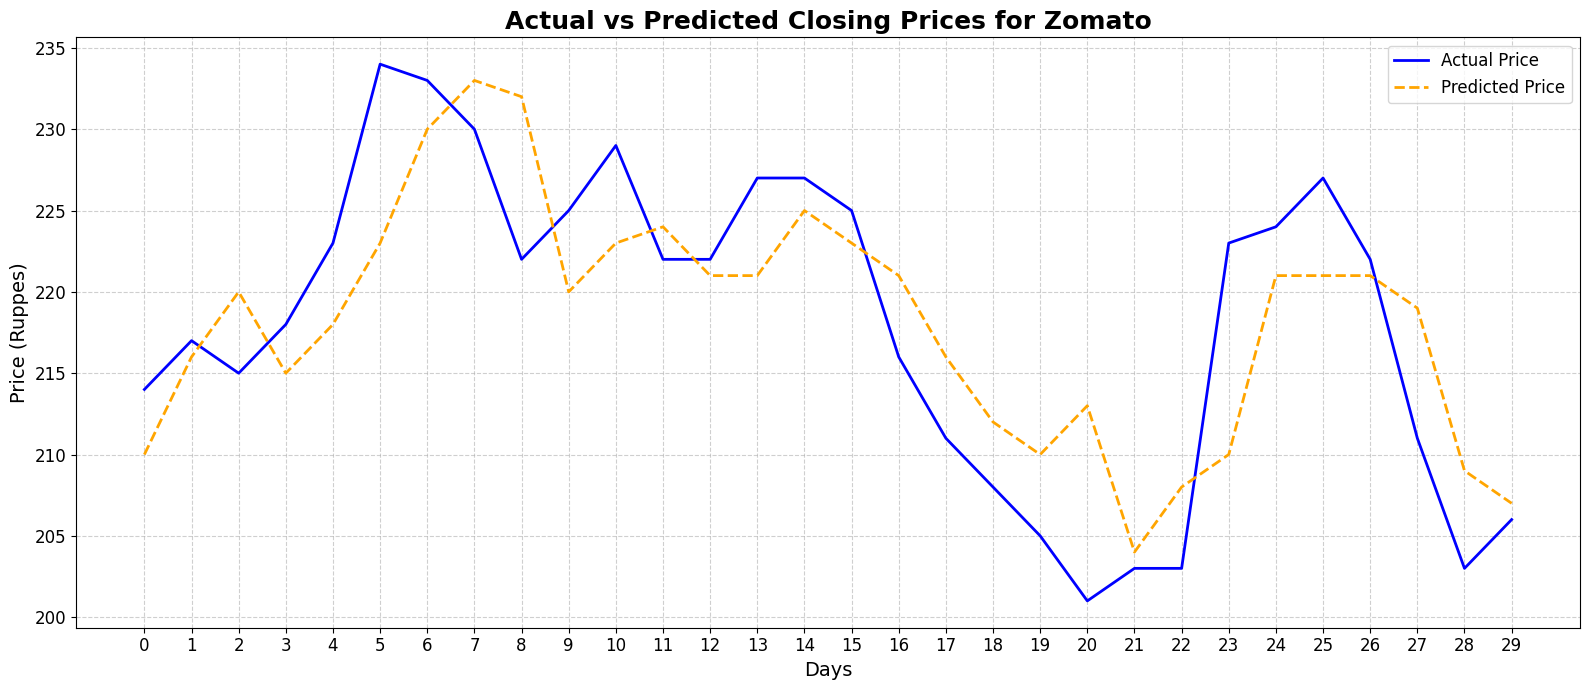

In [52]:
# Reset index for alignment
y_test_aligned = y_test_reg.reset_index(drop=True)
y_pred_aligned = pd.Series(y_pred_reg, name='Predicted_Price')

# Plot
plt.figure(figsize=(16, 7))
plt.plot(y_test_aligned, label='Actual Price', color='blue', linewidth=2)
plt.plot(y_pred_aligned.round(), label='Predicted Price', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Closing Prices for Zomato', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('Price (Ruppes)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12, ticks=range(len(y_test_aligned)))
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------------

# Trading Signals Generated

In [ ]:
df = pd.DataFrame({"Actual": y_test_aligned, "Predicted": y_pred_aligned.round()})

df['actual_before'] = df['Actual'].shift(1)

# Signal Calculation wih my strategy
df["Signal"] = np.where(df["actual_before"].isnull(), "HOLD",
                    np.where((df["Predicted"] - df["actual_before"]) > 0, "BUY",
                        np.where((df["Predicted"] - df["actual_before"]) == 0, "HOLD", "SELL")
                    )
                )

df.head()

,Actual,Predicted,actual_before,Signal
0,214.0,210.0,NaN,HOLD
1,217.0,216.0,214.0,BUY
2,215.0,220.0,217.0,BUY
3,218.0,215.0,215.0,HOLD
4,223.0,218.0,218.0,HOLD


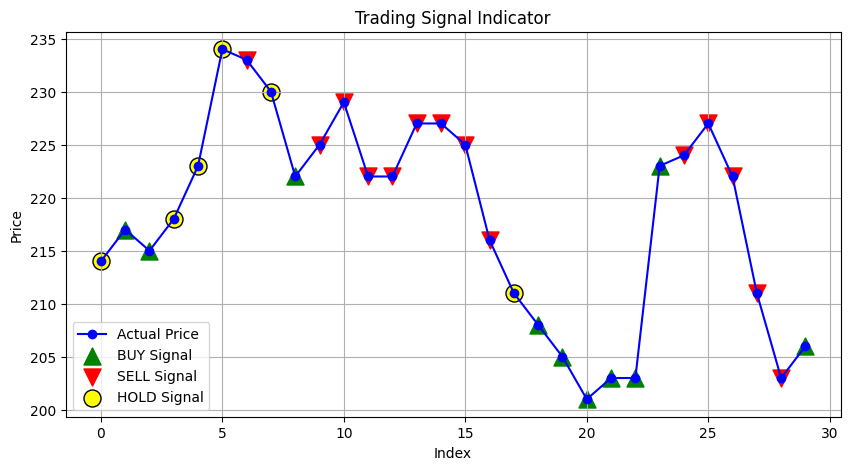

In [103]:
# Create figure and axis
plt.figure(figsize=(10, 5))

# Plot Actual Prices as a Line Graph
plt.plot(df.index, df["Actual"], marker="o", linestyle="-", color="blue", label="Actual Price")

# Plot BUY signals (Green ↑)
buy_signals = df[df["Signal"] == "BUY"]
plt.scatter(buy_signals.index, buy_signals["Actual"], color="green", marker="^", s=150, label="BUY Signal")

# Plot SELL signals (Red ↓)
sell_signals = df[df["Signal"] == "SELL"]
plt.scatter(sell_signals.index, sell_signals["Actual"], color="red", marker="v", s=150, label="SELL Signal")

# Plot HOLD signals (Yellow ●)
hold_signals = df[df["Signal"] == "HOLD"]
plt.scatter(hold_signals.index, hold_signals["Actual"], color="yellow", marker="o", s=150, edgecolors="black", label="HOLD Signal")

# Labels and title
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Trading Signal Indicator")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------

# Thank you!!!